In [1]:
# Import libraries
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from rdkit.Chem import AllChem, MolFromSmiles, DataStructs, rdFingerprintGenerator
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


sns.set_style()

# Import libraries
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.dummy import DummyRegressor
from model_screener import ModelScreener
sns.set_style()

In [5]:
# Read data
train_data = pd.read_csv(Path("../data/train_data.csv"))
test_data = pd.read_csv(Path("../data/test_data.csv"))
train_labels = pd.read_csv(Path("../data/train_labels.csv"))
test_labels = pd.read_csv(Path("../data/test_labels.csv"))

# Generation of Morgan Fingerprints

In [14]:
def generate_ecfp4(smiles_list, radius=2, nBits=2048) -> np.array:
    fingerprints = []
    for smi in smiles_list:
        mol = MolFromSmiles(smi)
        if mol is None:
            print(f"Invalid SMILES string: {smi}")
            continue
        
        # Setup fingerprint generator
        fp_generator = AllChem.GetMorganGenerator(radius=radius)
        fingerprint = fp_generator.GetFingerprintAsNumPy(mol)
        fingerprints.append(fingerprint)
    return np.array(fingerprints)

# Generate ECFP4 fingerprints and convert labels to numpy array
train_fingerprints = generate_ecfp4(train_data["SMILES"])
test_fingerprints = generate_ecfp4(test_data["SMILES"])
train_labels = np.array(train_labels).ravel()
test_labels = np.array(test_labels).ravel()

print("Shape of Fingerprints (train):", train_fingerprints.shape)
print("Shape of Solubility Values (train):", train_labels.shape)
print("Shape of Fingerprints (test):", test_fingerprints.shape)
print("Shape of Solubility Values (test):", test_labels.shape)

[17:08:12] WARNING: not removing hydrogen atom without neighbors
[17:08:12] WARNING: not removing hydrogen atom without neighbors
[17:08:12] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not r

Shape of Fingerprints (train): (7591, 2048)
Shape of Solubility Values (train): (7591,)
Shape of Fingerprints (test): (1898, 2048)
Shape of Solubility Values (test): (1898,)


[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:13] WARNING: not removing hydrogen atom without neighbors
[17:08:14] WARNING: not removing hydrogen atom without neighbors
[17:08:14] WARNING: not removing hydrogen atom without neighbors
[17:08:14] WARNING: not removing hydrogen atom without neighbors
[17:08:14] WARNING: not removing hydrogen atom without neighbors


# Model screening

In [15]:
# Create a dictionary of regression models
regression_models = {
    "dummy": DummyRegressor(),
    'linear_regression': LinearRegression(),
    'svr': SVR(),
    'random_forest': RandomForestRegressor(),
    'gb_regression': GradientBoostingRegressor(),
    'knn_regression': KNeighborsRegressor(),
    'mlp_regression': MLPRegressor(random_state=42),
}

# Set up screening object for regression and continuous ring values
regression_screener_cont = ModelScreener(
    x_train=train_fingerprints,
    y_train=train_labels,
    models=regression_models,
    metrics="neg_root_mean_squared_error",
    cv=5)

# Perform screening for regression
regression_screener_cont.screen_models()
# Transform results into dataframe
regression_screener_cont.transform_to_df()
results = regression_screener_cont.results_df
# Convert negative RMSE to absolute values
results = results.assign(score_mean=results.loc[:, "score_mean"].abs())

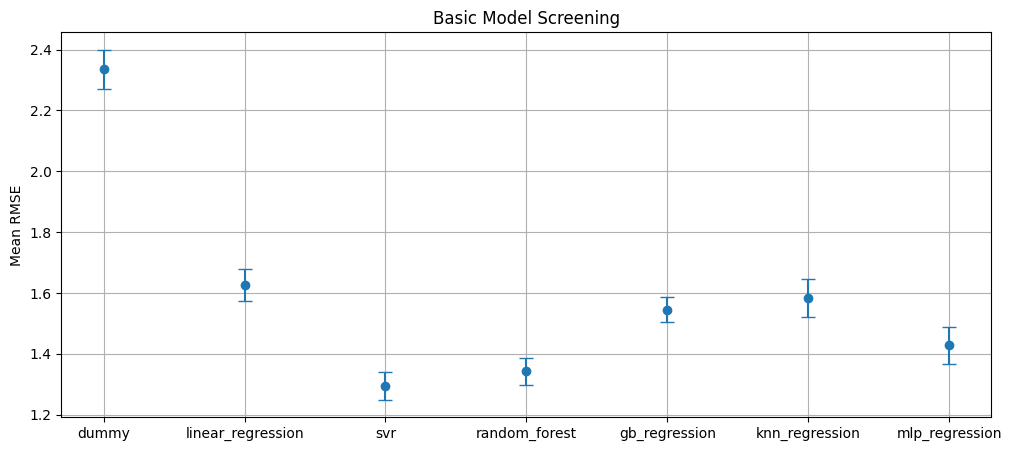

In [16]:
# Plot results
plt.figure(figsize=(12,5))
plt.errorbar(results.index, results['score_mean'], yerr=results['score_stdev'], fmt='o', capsize=5)
plt.ylabel("Mean RMSE")
plt.title("Basic Model Screening")
plt.grid(True)
plt.show()

# Fine tuning

In [18]:
# Define hyperparameter space for SVR
svr_params = {
    'C': uniform(0.1, 10),
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
}

# Perform random search for SVR
svr_regressor = SVR()
svr_search = RandomizedSearchCV(
    estimator=svr_regressor,
    param_distributions=svr_params,
    n_jobs=-1,
    cv=3,
    verbose=1,
    scoring='neg_root_mean_squared_error'
)

svr_search.fit(train_fingerprints, train_labels)

#--------------------------------------------------------------

# Define hyperparameter space for MLPRegressor
mlp_params = {
    'hidden_layer_sizes': [(25, 25,), (50, 50, 50), (100, 50, 25), (25, 25, 25, 25, 25, 25, 25, 25), (50, 50, 50, 50, 50)],
    'activation': ['relu', 'tanh'],
    "solver": ["adam"],
    'alpha': np.logspace(-5, 2, 8),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': randint(100, 500)
}

# Perform random search for MLP
mlp_regressor = MLPRegressor()
mlp_search = RandomizedSearchCV(
    estimator=mlp_regressor,
    param_distributions=mlp_params,
    n_jobs=-1,
    cv=3,
    verbose=1,
    scoring='neg_root_mean_squared_error'
)

mlp_search.fit(train_fingerprints, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (135) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (135) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

RandomizedSearchCV(cv=3, estimator=MLPRegressor(), n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'hidden_layer_sizes': [(25, 25),
                                                               (50, 50, 50),
                                                               (100, 50, 25),
                                                               (25, 25, 25, 25,
                                                                25, 25, 25,
                                                                25),
                                                               (50, 50, 50, 50,
                                                                50)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4a822072f0>,
                                        'solver': ['adam']},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [21]:
# Access the best hyperparameters, best models and best scores
best_svr_params = svr_search.best_params_
best_svr_model = svr_search.best_estimator_
best_svr_score = svr_search.best_score_

best_mlp_params = mlp_search.best_params_
best_mlp_model = mlp_search.best_estimator_
best_mlp_score = mlp_search.best_score_

# Create dataframe
fine_tuning_df = pd.DataFrame(
    data=[
        [best_svr_params, abs(best_svr_score)],
        [best_mlp_params, abs(best_mlp_score)]
        ],
    columns=["Best params", "Best score"],
    index=["SVR", "MLP"])
fine_tuning_df

,Best params,Best score
SVR,"{'C': 4.321132083763903, 'gamma': 'scale'}",1.222487
MLP,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",1.325175


In [24]:
# Save SVR model
filepath_svr = Path("../models/svr_fingerprints.pkl")
joblib.dump(best_svr_model, filepath_svr)

['../models/svr_fingerprints.pkl']

# Ensemble of descriptor and fingerprint model

In [25]:
# Load models
filepath_svr = Path("../models/svr_fingerprints.pkl")
filepath_stacking = Path("../models/stacking_model.pkl")
fingerprint_model = joblib.load(filepath_svr)
descriptor_model = joblib.load(filepath_stacking)

In [26]:
# Prepare descriptor datasets
descriptors = ["MolWt", "MolLogP", "MolMR", "HeavyAtomCount", "NumHDonors",
               "NumRotatableBonds", "NumValenceElectrons", "NumAromaticRings",
               "LabuteASA", "BertzCT", "C", "Cl", "Na", "Br", "F", "K", "O" ]
train_descriptors = train_data.loc[:, descriptors]
test_descriptors = test_data.loc[:, descriptors]

In [27]:
def descriptor_fingerpring_model(descriptor_model, fingerprint_model, descriptor_data, fingerprint_data):
    descriptor_pred = descriptor_model.predict(descriptor_data)
    fingerprint_pred = fingerprint_model.predict(fingerprint_data)
    return (descriptor_pred + fingerprint_pred) / 2

In [58]:
train_predictions = descriptor_fingerpring_model(
    descriptor_model=descriptor_model,
    fingerprint_model=fingerprint_model,
    descriptor_data=train_descriptors,
    fingerprint_data=train_fingerprints)

In [62]:
rmse_score = root_mean_squared_error(y_pred=train_predictions, y_true=train_labels)
rmse_score

0.5189377240668773

In [63]:
test_predictions = descriptor_fingerpring_model(
    descriptor_model=descriptor_model,
    fingerprint_model=fingerprint_model,
    descriptor_data=test_descriptors,
    fingerprint_data=test_fingerprints)

In [64]:
rmse_score = root_mean_squared_error(y_pred=test_predictions, y_true=test_labels)
rmse_score

1.0001578201714132